In [ ]:
!pip install --user gym

In [ ]:
import numpy as np
import gym
import time
import random
from IPython.display import clear_output

In [ ]:
env = gym.make("FrozenLake-v1")

In [ ]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n


qtable = np.zeros((state_space_size,action_space_size))
print(qtable)

In [ ]:
total_episodes = 1500       # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.005

In [ ]:
# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0

    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)

        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

        total_rewards += reward

        # Our new state is state
        state = new_state

        # If done (if we're dead) : finish episode
        if done == True:
            break

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)
split_rewards = np.split(np.array(rewards), 10)
for i, rewards in enumerate(split_rewards):
    print((i+1) * 500, ':', np.mean(rewards))
print(qtable)

In [ ]:
env.reset()

for episode in range(5):
    state = env.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):

        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])

        new_state, reward, done, info = env.step(action)

        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            env.render()

            # We print the number of step it took.
            print("Number of steps", step)
            break
        state = new_state
env.close()

In [ ]:
#!/usr/bin/env python3

load_frozen_lake = __import__('0-load_env').load_frozen_lake
import numpy as np

np.random.seed(0)
env = load_frozen_lake()
print(env.desc)
print(env.P[0][0])
env = load_frozen_lake(is_slippery=True)
print(env.desc)
print(env.P[0][0])
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
print(env.desc)
env = load_frozen_lake(map_name='4x4')
print(env.desc)

In [ ]:
#!/usr/bin/env python3

load_frozen_lake = __import__('0-load_env').load_frozen_lake
q_init = __import__('1-q_init').q_init

env = load_frozen_lake()
Q = q_init(env)
print(Q.shape)
env = load_frozen_lake(is_slippery=True)
Q = q_init(env)
print(Q.shape)
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)
print(Q.shape)
env = load_frozen_lake(map_name='4x4')
Q = q_init(env)
print(Q.shape)

In [ ]:
from google.colab import files

files.upload()

In [ ]:
#!/usr/bin/env python3

load_frozen_lake = __import__('0-load_env').load_frozen_lake
q_init = __import__('1-q_init').q_init
epsilon_greedy = __import__('2-epsilon_greedy').epsilon_greedy
import numpy as np

desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)
Q[7] = np.array([0.5, 0.7, 1, -1])
np.random.seed(0)
print(epsilon_greedy(Q, 7, 0.5))
np.random.seed(1)
print(epsilon_greedy(Q, 7, 0.5))

In [ ]:
#!/usr/bin/env python3

load_frozen_lake = __import__('0-load_env').load_frozen_lake
q_init = __import__('1-q_init').q_init
train = __import__('3-q_learning').train
import numpy as np

np.random.seed(0)
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)

Q, total_rewards  = train(env, Q)
print(Q)
split_rewards = np.split(np.array(total_rewards), 10)
for i, rewards in enumerate(split_rewards):
    print((i+1) * 500, ':', np.mean(rewards))

In [ ]:
def bellman_equation(Q, state, action, reward, next_state, alpha, gamma):
    """performs the Bellman equation"""
    Q[state, action] = (Q[state, action] * (1 - alpha) +
                        (reward + gamma * np.max(Q[next_state, :])) * alpha)
    return Q


def train(env, Q,
          episodes=5000,
          max_steps=100,
          alpha=0.1, gamma=0.99,
          epsilon=1,
          min_epsilon=0.1,
          epsilon_decay=0.05):
    """teach agent how to play FrozenLake"""
    rewards = []
    for ep in range(episodes):
        state = env.reset()
        done = False
        total_rewards = 0
        for _ in range(max_steps):
            action = epsilon_greedy(Q, state, epsilon)
            new_state, reward, done, info = env.step(action)
            if done and reward == 0:
                reward = -1
            Q = bellman_equation(Q, state, action, reward,
                                 new_state, alpha, gamma)
            total_rewards += reward
            state = new_state
            if done:
                break

        epsilon = (min_epsilon + (epsilon - min_epsilon) *
                   np.exp(-epsilon_decay * ep))
        rewards.append(total_rewards)
    return Q, rewards

In [ ]:
from google.colab.patches import cv2_imshow

def play(env, Q, max_steps=100):
    state = (env.reset(),)
    total_reward = 0
    for _ in range(max_steps):
        frame = env.render(mode='rgb_array')  # Render the environment state as RGB image
        cv2_imshow(frame)  # Display the RGB frame using Google Colab's cv2_imshow
        # cv2.imshow('Environment State', frame)  # Alternative for local execution
        # cv2.waitKey(100)
        # print(env.render(mode="rgb_array"))  # Render the environment state
        action = np.argmax(Q[state])
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            frame = env.render(mode='rgb_array')  # Render the final environment state
            cv2_imshow(frame)  # Display the final state
            # print(env.render(mode="rgb_array"))  # Alternative for local execution
            break
    # cv2.destroyAllWindows()  # Not needed for Google Colab
    return total_reward


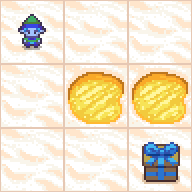

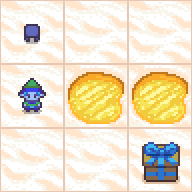

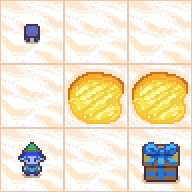

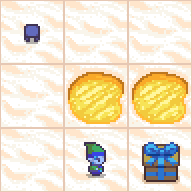

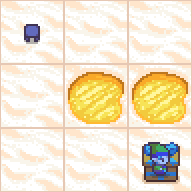

1.0


In [16]:
#!/usr/bin/env python3

load_frozen_lake = __import__('0-load_env').load_frozen_lake
q_init = __import__('1-q_init').q_init


import numpy as np

np.random.seed(0)
desc = [['S', 'F', 'F'], ['F', 'H', 'H'], ['F', 'F', 'G']]
env = load_frozen_lake(desc=desc)
Q = q_init(env)

Q, total_rewards  = train(env, Q)
print(play(env, Q))